In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from lidar_diff_ray_casting import (
    diff_ray_casting_3d,
    get_voxel_centers_torch_tensor,
    voxel_distance_to_point,
    get_out_of_grid_dist_batch
)

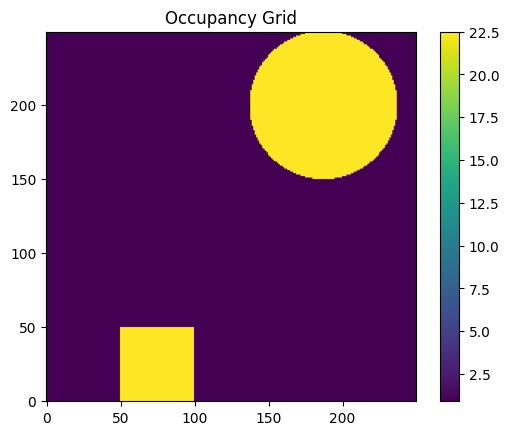

In [3]:
# Define sensor origin and ray directions
# %%
sensor_origin = np.array([0.0, 0.0, 0.9], dtype=np.float32)
grid_min = np.array([-50.0, -50.0, 0.0], dtype=np.float32)
grid_max = np.array([50.0, 50.0, 10.0], dtype=np.float32)
voxel_size = np.array([0.4, 0.4, 0.4], dtype=np.float32)
# create occupancy tensor based on grid boundaries and cell size
occupancy_shape = (
    int((grid_max[0] - grid_min[0]) / voxel_size[0]),
    int((grid_max[1] - grid_min[1]) / voxel_size[1]),
    int((grid_max[2] - grid_min[2]) / voxel_size[2]),
)
occupancy = torch.ones(occupancy_shape, dtype=torch.float32)*1.0e-8

# assign the ground plane occupancy
occupancy[:, :, 0] = 0.9

# add an infinite height cylinder at the center (30.0, 25.0)
cylinder_center = torch.tensor([30.0, 25.0, 0.0], dtype=torch.float32)
cylinder_radius = 20.0
# generate a meshgrid of grid centers
x = torch.arange(
    grid_min[0] + voxel_size[0] / 2,
    grid_max[0],
    voxel_size[0],
    dtype=torch.float32,
)
y = torch.arange(
    grid_min[1] + voxel_size[1] / 2,
    grid_max[1],
    voxel_size[1],
    dtype=torch.float32,
)
z = torch.arange(
    grid_min[2] + voxel_size[2] / 2,
    grid_max[2],
    voxel_size[2],
    dtype=torch.float32,
)
grid_centers_xy = torch.meshgrid(x, y, indexing="ij")
grid_centers_xy = torch.stack(grid_centers_xy, dim=-1)

grid_centers_xy = grid_centers_xy.reshape(
    occupancy_shape[0], occupancy_shape[1], 1, 2
)  # shape: (x, y, 1, 2)
# repeat the z dimension to match occupancy shape
grid_centers_xy = grid_centers_xy.repeat(1, 1, occupancy_shape[2], 1)

# set all grid cells within the cylinder radius to occupied
distances = torch.norm(
    grid_centers_xy
    - cylinder_center[torch.newaxis, torch.newaxis, torch.newaxis, :2],
    dim=-1,
)
occupancy[distances <= cylinder_radius] = 0.9

# add a slanted cube
cube_center = torch.tensor([-40.0, -20.0, 0], dtype=torch.float32)
cube_size = 20.0
for height in range(0, occupancy.shape[2]):
    center_x = cube_center[0]
    center_y = cube_center[1]
    # calculate the indices of the cube in the occupancy grid
    x_start = int((center_x - cube_size / 2 - grid_min[0].item()) / voxel_size[0].item())
    x_end = int((center_x + cube_size / 2 - grid_min[0].item()) / voxel_size[0].item())
    y_start = int((center_y - cube_size / 2 - grid_min[1].item()) / voxel_size[1].item())
    y_end = int((center_y + cube_size / 2 - grid_max[1].item()) / voxel_size[1].item())
    z_start = height
    z_end = height + 1
    occupancy[x_start:x_end, y_start:y_end, z_start:z_end] = 0.9
#
plt.imshow(
    torch.sum(occupancy, dim=2).numpy(),
)
plt.title("Occupancy Grid")
# invert yaxis
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

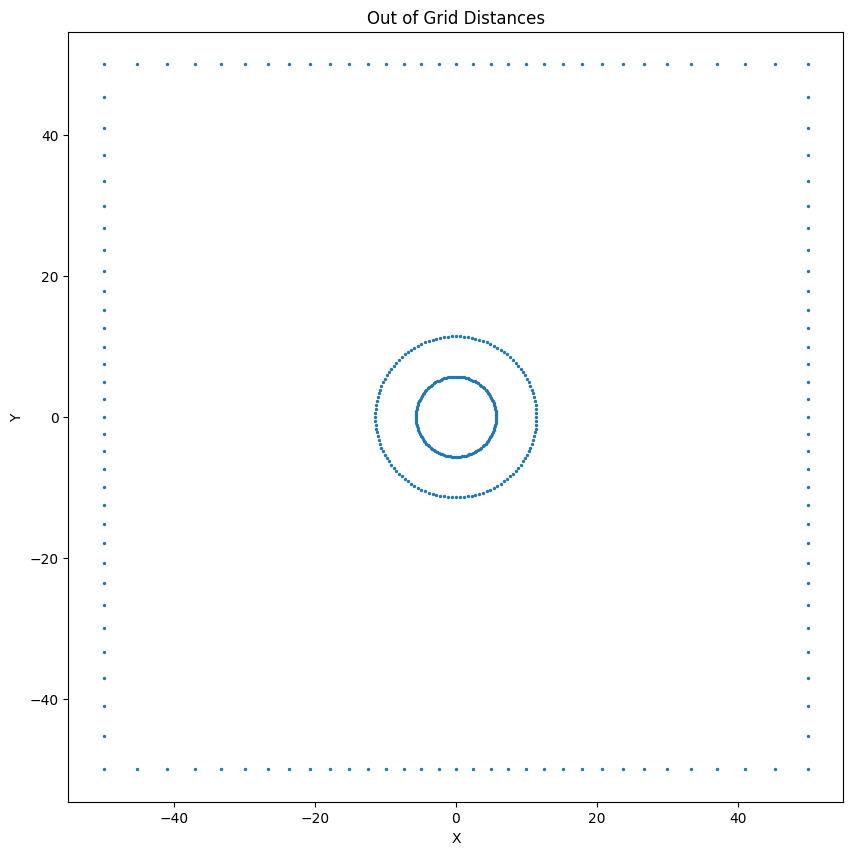

In [4]:
# %% define ray directions
n_ray = 128
azimuth = np.arange(0, 2 * np.pi, 2 * np.pi / n_ray)
elevation = np.array([-np.pi / 20, -np.pi / 40, 0.0])
# generate a meshgrid of azimuth and elevation
azimuth_grid, elevation_grid = np.meshgrid(
    azimuth, elevation, indexing="ij"
)
azimuth_grid = azimuth_grid.reshape(-1)
elevation_grid = elevation_grid.reshape(-1)
ray_directions = np.stack(
    [
        np.cos(azimuth_grid) * np.cos(elevation_grid),
        np.sin(azimuth_grid) * np.cos(elevation_grid),
        np.sin(elevation_grid),
    ],
    axis=-1,
)
# %% compute the distance of every voxel center to the sensor origin
voxel_centers = get_voxel_centers_torch_tensor(
    grid_min, grid_max, voxel_size
)
dist_to_sensor = voxel_distance_to_point(
    voxel_centers,
    torch.tensor(sensor_origin, dtype=torch.float32),
)
out_of_grid_dists = get_out_of_grid_dist_batch(
    sensor_origin,
    ray_directions,
    grid_min,
    grid_max,
)
out_of_grid_dists = torch.tensor(out_of_grid_dists, dtype=torch.float32)

# plot the out of grid distances on the 2d plane
plt.figure(figsize=(10, 10))
d = out_of_grid_dists.detach().cpu().numpy()
plt.scatter(ray_directions[:, 0] * d, ray_directions[:, 1] * d, s=2)
plt.axis("equal")
plt.title("Out of Grid Distances")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


Using GPU for computations


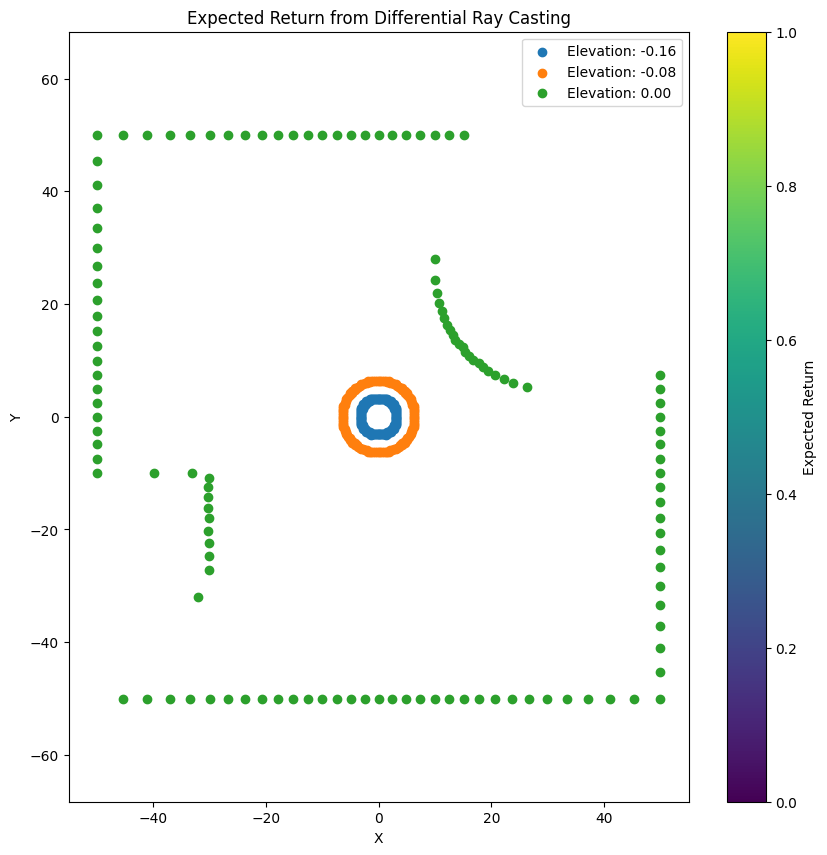

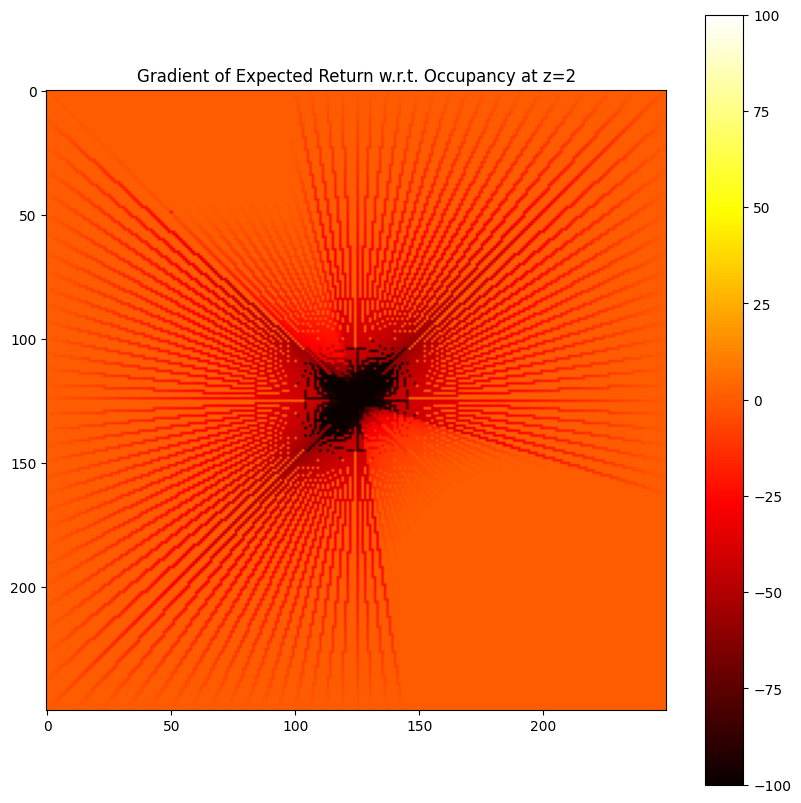

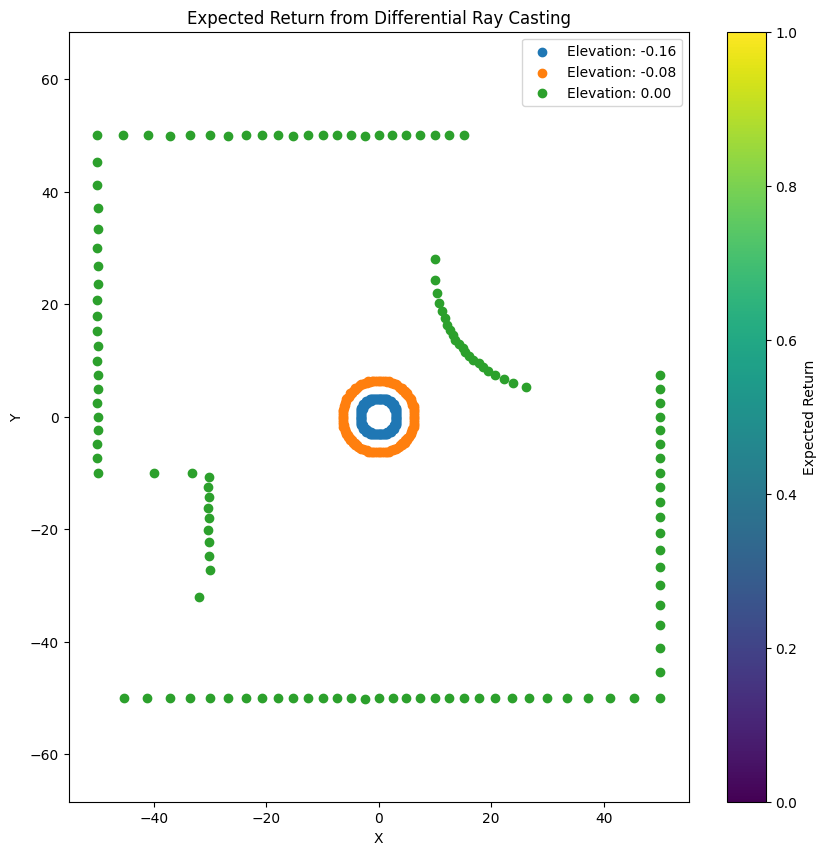

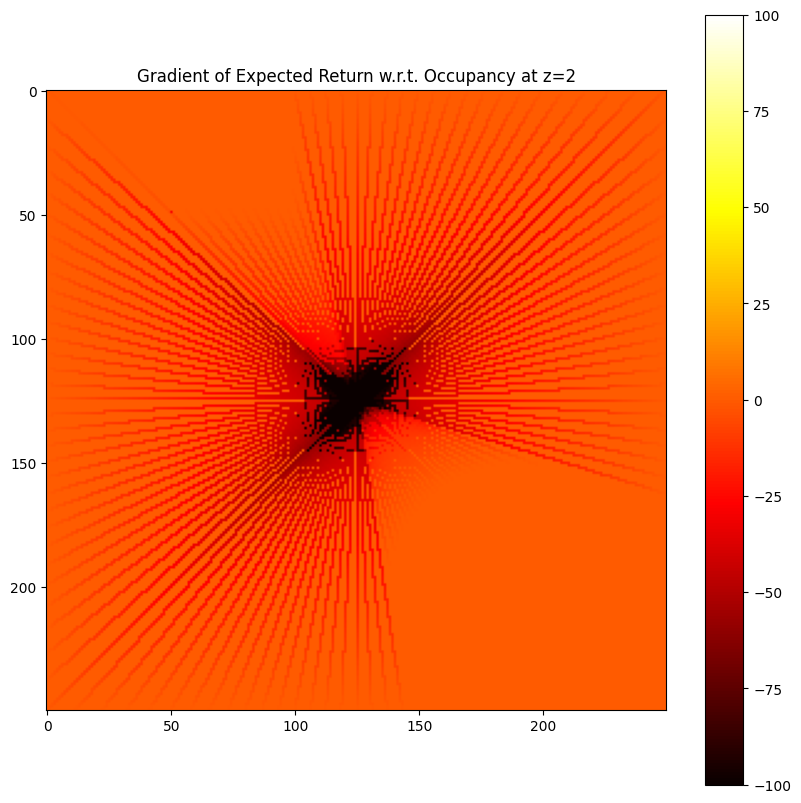

In [5]:
# %% send all to GPU if available
if torch.cuda.is_available():
    print("Using GPU for computations")
    occupancy = occupancy.cuda()
    voxel_centers = voxel_centers.cuda()
    dist_to_sensor = dist_to_sensor.cuda()
    out_of_grid_dists = out_of_grid_dists.cuda()
# %% perform differential ray casting
for pad_mode in ["same", "flat"]:
    occu = occupancy.clone()
    occu.requires_grad_(True)
    occu.grad = None
    expected_return = diff_ray_casting_3d(
        sensor_origin=sensor_origin,
        ray_directions=ray_directions,
        grid_min=grid_min,
        grid_max=grid_max,
        voxel_size=voxel_size,
        occupancy=occu,
        vox_dist_to_sensor=dist_to_sensor.clone(),
        out_of_grid_dists=out_of_grid_dists.clone(),
        pad_mode=pad_mode,
    )
    expected_return.sum().backward()

    # plot the expected return on the 2D plane
    # use different color for different elevation value
    plt.figure(figsize=(10, 10))
    expected_return_np = expected_return.detach().cpu().numpy()
    for i, elev in enumerate(np.unique(elevation_grid)):
        mask = elevation_grid == elev
        r = expected_return_np[mask]
        x = r * np.cos(azimuth_grid[mask])
        y = r * np.sin(azimuth_grid[mask])
        plt.scatter(
            x,
            y,
            label=f"Elevation: {elev.item():.2f}",
        )
    plt.axis("equal")
    plt.title("Expected Return from Differential Ray Casting")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.colorbar(label="Expected Return")
    plt.savefig(f"expected_return_pad_mode_{pad_mode}.png")
    # plot the gradient
    g = occu.grad.cpu().numpy()  # type: ignore
    plt.figure(figsize=(10, 10))
    j=2
    plt.imshow(
        g[:, :, j],
        cmap="hot",
        vmin=-100.0,
        vmax=100.0
    )
    plt.title(f"Gradient of Expected Return w.r.t. Occupancy at z={j}")
    plt.colorbar()
    plt.show()


In [6]:
# %% benchmark the performance
import time
# pad mode "same"
start_time = time.time()
for _ in range(20):
    expected_return_same = diff_ray_casting_3d(
        sensor_origin=sensor_origin,
        ray_directions=ray_directions,
        grid_min=grid_min,
        grid_max=grid_max,
        voxel_size=voxel_size,
        occupancy=occupancy,
        vox_dist_to_sensor=dist_to_sensor,
        out_of_grid_dists=out_of_grid_dists,
        pad_mode="same",
    )
end_time = time.time()
avg_time_pad_same = (end_time - start_time) / 100

# pad mode "flat"
start_time = time.time()
for _ in range(20):
    expected_return_flat = diff_ray_casting_3d(
        sensor_origin=sensor_origin,
        ray_directions=ray_directions,
        grid_min=grid_min,
        grid_max=grid_max,
        voxel_size=voxel_size,
        occupancy=occupancy,
        vox_dist_to_sensor=dist_to_sensor,
        out_of_grid_dists=out_of_grid_dists,
        pad_mode="flat",
    )
end_time = time.time()
avg_time_pad_flat = (end_time - start_time) / 100


print(f"Average time per iteration for pad mode 'same': {avg_time_pad_same:.6f} seconds")
print(f"Average time per iteration for pad mode 'flat': {avg_time_pad_flat:.6f} seconds")

# compare the result
print(expected_return_same[:20])
print(expected_return_flat[:20])


Average time per iteration for pad mode 'same': 0.009487 seconds
Average time per iteration for pad mode 'flat': 0.005158 seconds
tensor([ 3.1304,  6.2868, 50.0000,  3.1304,  6.2868, 50.0603,  3.1304,  6.3122,
        50.2420,  3.1812,  6.3627, 50.5471,  3.1812,  6.4377, 26.7944,  3.1527,
         6.4087, 24.6376,  3.2801,  6.5337], device='cuda:0')
tensor([ 3.1304,  6.2868, 50.0002,  3.1304,  6.2868, 50.0584,  3.1304,  6.3120,
        50.2397,  3.1812,  6.3626, 50.5456,  3.1812,  6.4376, 26.7936,  3.1527,
         6.4087, 24.6376,  3.2801,  6.5341], device='cuda:0')
